In [79]:
import warnings
warnings.filterwarnings('ignore')
import picaso.justdoit as jdi
from numba import jit
import picaso.climate as climate
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## What is this part of Picaso trying to do?

This is the tutorial to run a 1D Radiative-Convective Equilibrium Model to solve for atmospheric structures of brown dwarfs and exoplanets. A brown dwarf or exoplanet atmosphere can be divided into different physical components :-

1\. The Temperature Structure (T(P) profile)
 
2\. The Chemical Structure 

3\. Energy Transport in the atmosphere (Radiative Transfer)

4\. Clouds 

But these physical components are not independent of each other. For example, the chemistry is dependant on the T(P) profile, the radiative transfer is dependant on clouds and the chemistry and so on. 

This code here tries to find the atmospheric state of your object by taking care of all of these processes and their interconnections self-consistently.

So lets begin ...




## Let's first try to model a brown dwarf you are perhaps interested in

What are the properties of your brown dwarf of interest ? What is its effective temperature and what is its gravity ? 

In [80]:
T_eff= 1000 # Effective Temperature of your Brown Dwarf in K
grav = 1000 # Gravity of your brown dwarf in m/s/s

cl_run = jdi.inputs(calculation="brown", climate = True) # start a calculation 

cl_run.gravity(gravity=grav, gravity_unit=u.Unit('m/(s**2)')) # input gravity
cl_run.T_eff(Teff=T_eff) # input effective temperature



T_star = "NA" # K, As it is a isolated brown dwarf, these params are not needed so 'NA'
semi_major = "NA" # AU,  As it is a isolated brown dwarf, these params are not needed so 'NA'
# ignore this for now
self_consistent_kzz= False # Only needed if you want to do on-the-fly calculation with MLT Kzz



Let's now grab our gaseos opacities. This code uses a correlated-k approach for dealing with opacities. In order to do that, you must decide what is the metallicity of the atmosphere you are going after and what is the CtoO ratio. Note how the opannection function is run with different keywords now.

In [81]:
mh = '+0.0' #log metallicity
CtoO = '1.0' # CtoO ratio


filename_db="/Users/sagnickmukherjee/Documents/GitHub/picaso-dev/reference/opacities/ck_cx_cont_opacities.db"
ck_db='/Users/sagnickmukherjee/Documents/software/picaso-dev/reference/opacities/ck_db/m'+mh+'_co'+CtoO+'.data.196'

opacity_ck = jdi.opannection(ck=True, ck_db=ck_db,filename_db=filename_db) # grab your opacities


As is always the case with models, you also need to set-up a grid to do all your calculations. Here you need to divide the atmosphere of your object in 1D plane-parallel levels. We recommend any number of levels between 51-91 depending on your needs. Then you also need to decide the physical extent of the atmosphere this grid belongs to. 

Intuitively, you might think as this grid to be of vertical height but our model uses a grid of atmospheric pressure instead. 

Low pressure -----> upper Atmosphere
High pressure -----> Deeper Atmosphere

Therefore, you need to specify the maximum pressure and minimum pressure of your atmospheric grid

In [82]:
nlevel = 91 # number of plane-parallel levels in your code

#Lets set the max and min at 1e-4 bars and 500 bars

Pmin = 1e-4 #bars
Pmax = 500 #bars
pressure=np.logspace(np.log10(Pmin),np.log10(Pmax),nlevel) # set your pressure grid


You also need to assume a guess temperature pressure profile to start things off with the code. A good go-to guess always is the published SONORA grid. But lets start things off with a very bad guess of an isothermal atmosphere.

In [83]:
temp_guess = np.zeros(shape=(nlevel))

temp_guess += 500 # K , isothermal atmosphere guess


You also need to have a crude guess of the convective zone of your atmosphere. Generally the deeper atmosphere is always convective. Again a good guess is always the published SONORA grid of models for this. But lets assume that the bottom 7 levels of the atmosphere is convective. 

In [84]:

    
nofczns = 1 # number of convective zones initially, don't change this 

nstr_upper = 86 # top most level of guessed convective zone
nstr_deep = nlevel -2 # this is always the case. Dont change this
nstr = np.array([0,nstr_upper,nstr_deep,0,0,0]) # initial guess of convective zones

# Here are some other parameters needed for the code.
rfacv = 0.0 # This is for stellar incident radiation. This is zero for brown dwarfs as we are not concerned with stellar radiation.
rfaci =1.0 # This is 1 always.
cloudy = False # not cloudy
fsed = 0.0 # as not cloudy so won't matter

    

Now we would use the inputs_climate function to input everything together to our cl_run we started.

In [85]:

cl_run.inputs_climate(temp_guess= temp_guess, pressure= pressure, nstr = nstr, nofczns = nofczns , rfacv = rfacv, rfaci = rfaci, cloudy = cloudy, mh = mh, CtoO = CtoO,species = ['MgSiO3','Mg2SiO4','Fe'], fsed = fsed)


 The actual climate code can be run with the cl_run.run command. The save_all_profiles is set to True to save the T(P) profile at all steps. The code will now iterate from your guess to reach the correct atmospheric solution for your brown dwarf of interest.
 Okay !!! We are all set to do our run. Let's hope for the best...
 
 

In [ ]:
pressure , temp, dtdp, nstr_new, flux_plus_final, df, all_profiles = cl_run.run_climate_model(opacity_ck,save_all_profiles=True, save_all_kzz = False,diseq_chem = False, self_consistent_kzz =self_consistent_kzz,vulcan_run = False)


Iteration number  0 , min , max temp  499.9904958379585 720.7318437809948 , flux balance  -0.9374813667223991
Iteration number  1 , min , max temp  499.9166227393104 1129.5300672266694 , flux balance  -0.9365669810277342
Iteration number  2 , min , max temp  499.01925963222993 1924.2401829869198 , flux balance  -0.7536400240644648
Iteration number  3 , min , max temp  488.18686639001675 1975.7893008958606 , flux balance  -0.6636005042590909
Iteration number 

# Let's see how our run tallies with the SONORA bobcat published models

Text(0.5, 1.0, 'T$_{\\rm eff}$= 1000 K, log(g)=5.0')

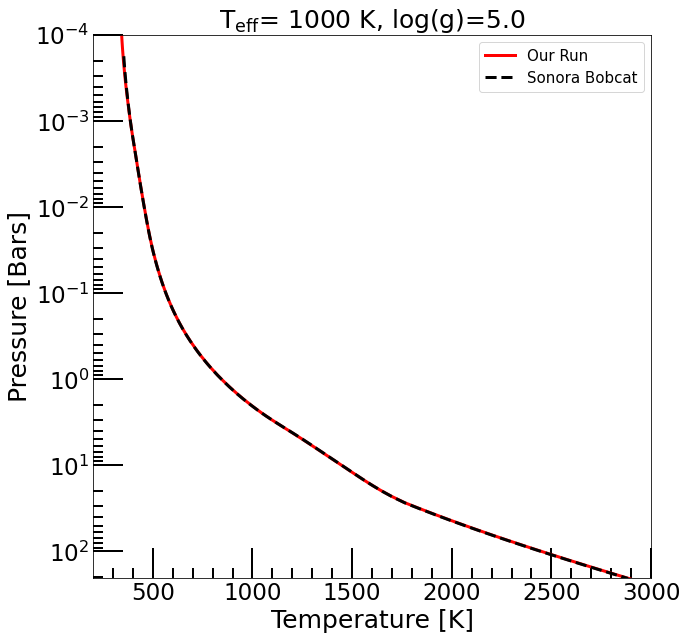

In [9]:
pressure_bobcat,temp_bobcat = np.loadtxt("/Users/sagnickmukherjee/Documents/GitHub/Disequilibrium-Picaso/t"+str(1000)+"g1000"+"nc_m0.0.dat",usecols=[1,2],unpack=True, skiprows = 1)

plt.figure(figsize=(10,10))
plt.ylabel("Pressure [Bars]", fontsize=25)
plt.xlabel('Temperature [K]', fontsize=25)
plt.ylim(205,1e-4)
plt.xlim(200,3000)

plt.semilogy(temp,pressure,color="r",linewidth=3,label="Our Run")

plt.semilogy(temp_bobcat,pressure_bobcat,color="k",linestyle="--",linewidth=3,label="Sonora Bobcat")


plt.minorticks_on()
plt.tick_params(axis='both',which='major',length =30, width=2,direction='in',labelsize=23)
plt.tick_params(axis='both',which='minor',length =10, width=2,direction='in',labelsize=23)

plt.legend(fontsize=15)

plt.title(r"T$_{\rm eff}$= 1000 K, log(g)=5.0",fontsize=25)



# We can also try to see how our initial guess of an isothermal atmosphere was changed by the code to reach the current solution

In [41]:
t_eq,p_eq,df_eq,all_profiles_eq = np.copy(temp), np.copy(pressure), df,np.copy(all_profiles)

In [ ]:
print(len(all_profiles_eq))

In [46]:

def dtdp(p,t):
    dtdp = np.zeros(len(t))
    for i in range(len(p)-1):
        dtdp[i] = np.log10(t[i+1]/t[i])/np.log10(p[i+1]/p[i])
    dtdp[-1] = dtdp[-2]
    return dtdp 

def did_grad_cp( t, p, t_table, p_table, grad, cp, calc_type):
    """
    Parameters
    ----------
    t : float
        Temperature  value
    p : float 
        Pressure value
    t_table : array 
        array of Temperature values with 53 entries
    p_table : array 
        array of Pressure value with 26 entries
    grad : array 
        array of gradients of dimension 53*26
    cp : array 
        array of cp of dimension 53*26
    calc_type : int 
        not used to make compatible with nopython. 
    
    Returns
    -------
    float 
        grad_x,cp_x
    
    """
    # Python version of DIDGRAD function in convec.f in EGP
    # This has been benchmarked with the fortran version
    
       
    temp_log= log10(t)
    pres_log= log10(p)
    
    pos_t = locate(t_table, temp_log)
    pos_p = locate(p_table, pres_log)

    ipflag=0
    if pos_p ==0: ## lowest pressure point
        factkp= 0.0
        ipflag=1
    elif pos_p ==25 : ## highest pressure point
        factkp= 1.0
        pos_p=24  ## use highest point
        ipflag=1

    itflag=0
    if pos_t ==0: ## lowest pressure point
        factkt= 0.0
        itflag=1
    elif pos_t == 52 : ## highest temp point
        factkt= 1.0
        pos_t=51 ## use highest point
        itflag=1
    
    if (pos_p > 0) and (pos_p < 26) and (ipflag == 0):
        factkp= (-p_table[pos_p]+pres_log)/(p_table[pos_p+1]-p_table[pos_p])
    
    if (pos_t > 0) and (pos_t < 53) and (itflag == 0):
        factkt= (-t_table[pos_t]+temp_log)/(t_table[pos_t+1]-t_table[pos_t])

    
    gp1 = grad[pos_t,pos_p]
    gp2 = grad[pos_t+1,pos_p]
    gp3 = grad[pos_t+1,pos_p+1]
    gp4 = grad[pos_t,pos_p+1]

    cp1 = cp[pos_t,pos_p]
    cp2 = cp[pos_t+1,pos_p]
    cp3 = cp[pos_t+1,pos_p+1]
    cp4 = cp[pos_t,pos_p+1]


    

    grad_x = (1.0-factkt)*(1.0-factkp)*gp1 + factkt*(1.0-factkp)*gp2 + factkt*factkp*gp3 + (1.0-factkt)*factkp*gp4
    cp_x= (1.0-factkt)*(1.0-factkp)*cp1 + factkt*(1.0-factkp)*cp2 + factkt*factkp*cp3 + (1.0-factkt)*factkp*cp4
    cp_x= 10**cp_x
    
    
    return grad_x,cp_x
def locate(array,value):
    """
    Parameters
    ----------
    array : array
        Array to be searched.
    value : float 
        Value to be searched for.
    
    
    Returns
    -------
    int 
        location of nearest point by bisection method 
    
    """
    # this is from numerical recipes
    
    n = len(array)
    
    
    jl = 0
    ju = n
    while (ju-jl > 1):
        jm=int(0.5*(ju+jl)) 
        if (value >= array[jm]):
            jl=jm
        else:
            ju=jm
    
    if (value <= array[0]): # if value lower than first point
        jl=0
    elif (value >= array[-1]): # if value higher than first point
        jl= n-1
    
    return jl



t_table=np.loadtxt('reference/climate_INPUTS/tlog',usecols=[0],unpack=True)
p_table=np.loadtxt('reference/climate_INPUTS/plog',usecols=[0],unpack=True)

grad=np.zeros(shape=(53,26))
cp = np.zeros(shape=(53,26))

grad_inp, i_inp, j_inp = np.loadtxt('reference/climate_INPUTS/GRAD_FOR_PY_Y28',usecols=[0,1,2],unpack=True)
for i in range(len(grad_inp)):
    grad[int(i_inp[i]-1),int(j_inp[i]-1)]=grad_inp[i]


In [47]:
co,h2o,nh3,ch4,dtdp_arr,grad_arr = np.zeros(len(all_profiles_eq)),np.zeros(len(all_profiles_eq)),np.zeros(len(all_profiles_eq)),np.zeros(len(all_profiles_eq)),np.zeros(len(all_profiles_eq)),np.zeros(len(all_profiles_eq))
spec = np.zeros(shape =(int(len(all_profiles_eq)/91),196))
ct=0
for i in range(int(len(all_profiles_eq)/91)):
#for i in range(5):
    bd = jdi.inputs(calculation='brown')

    bd.phase_angle(0)
    bd.gravity(gravity=1000 , gravity_unit=u.Unit('m/s**2'))

    sonora_profile_db = '/Users/sagnickmukherjee/Documents/software/sonora/profile/'
    Teff_dummy = 1000
    bd.sonora(sonora_profile_db, Teff_dummy)
    
    bd.inputs['atmosphere']['profile']['pressure'] =p_eq
    bd.inputs['atmosphere']['profile']['temperature'] = all_profiles_eq[i*91:(i+1)*91]
    bd.premix_atmosphere(opacity_ck,bd.inputs['atmosphere']['profile'])
    
    df_spec = bd.spectrum(opacity_ck,full_output=True)
    spec[i,:] = df_spec['thermal']
    co[i*91:(i+1)*91] = bd.inputs['atmosphere']['profile']['CO']
    h2o[i*91:(i+1)*91] = bd.inputs['atmosphere']['profile']['H2O']
    nh3[i*91:(i+1)*91] = bd.inputs['atmosphere']['profile']['NH3']
    ch4[i*91:(i+1)*91] = bd.inputs['atmosphere']['profile']['CH4']
    dtdp_arr[i*91:(i+1)*91] = dtdp(p_eq,all_profiles_eq[i*91:(i+1)*91])
    for jj in range(len(all_profiles_eq[i*91:(i+1)*91])):
        grad_back,cp_back = did_grad_cp(all_profiles_eq[ct], p_eq[jj], t_table, p_table, grad, grad*0, 0)
        grad_arr[ct] = grad_back
        ct+=1
    #x,y = jdi.mean_regrid(1e4/df_spec['wavenumber'], df_spec['thermal'], R=500)
    
    
    


In [48]:
print(int(len(all_profiles_eq)/91))

79


In [49]:
wh = np.where( (1e4/df_spec['wavenumber'] > 0.0) & (1e4/df_spec['wavenumber'] < 6))
wv = 1e4/df_spec['wavenumber'][wh]


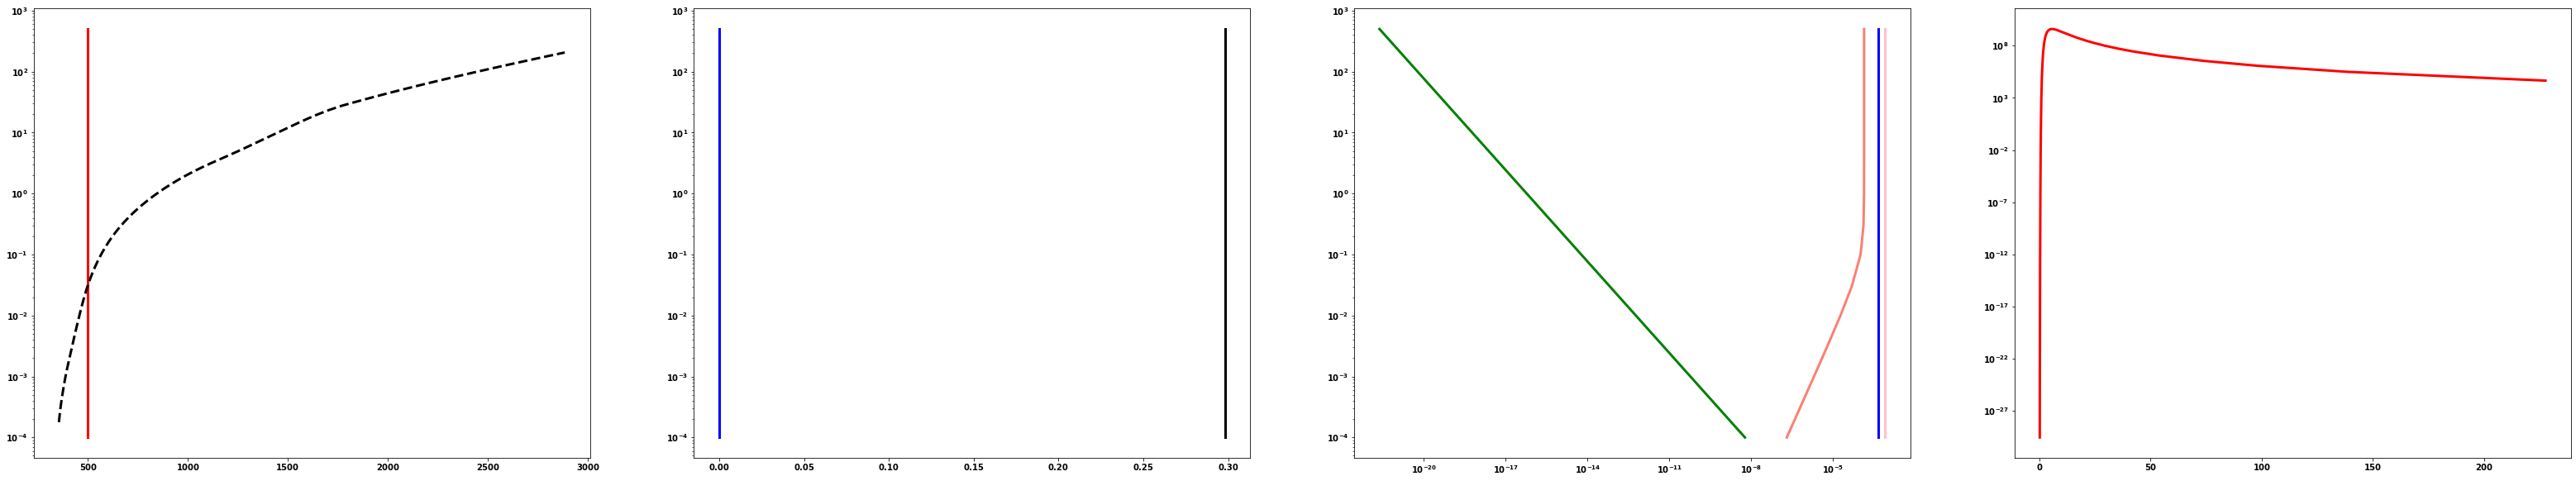

In [77]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

writergif = animation.PillowWriter(fps=3) 


x='''
AA.DD.BB.CC
'''
fig = plt.figure(figsize=(55,10))
ax = fig.subplot_mosaic(x,gridspec_kw={
        # set the height ratios between the rows
        "height_ratios": [1],
        # set the width ratios between the columns
        "width_ratios": [1,1,0.1,1,1,0.1,1,1,0.1,1,1]})

temp = all_profiles_eq[0*91:(0+1)*91]
line, = ax['A'].semilogy(temp, p_eq,linewidth=3,color='r',label="This Model")
line0, = ax['A'].semilogy(temp_bobcat,pressure_bobcat,color="k",linestyle="--",linewidth=3,label="SONORA Bobcat")

line1, = ax['B'].loglog(co[0:91], p_eq,linewidth=3,color='g',label="CO")
line2, = ax['B'].loglog(ch4[0:91], p_eq,linewidth=3,color='b',label="CH$_4$")
line3, = ax['C'].semilogy(1e4/df_spec['wavenumber'], spec[0,:],linewidth=3,color="r")
line4, = ax['B'].loglog(h2o[0:91], p_eq,linewidth=3,color='pink',label="H$_2$O")
line5, = ax['B'].loglog(nh3[0:91], p_eq,linewidth=3,color='salmon',label="NH$_3$")
line6, = ax['D'].semilogy(dtdp_arr[0:91], p_eq,linewidth=3,color='blue',label="Profile Lapse-Rate")
line7, = ax['D'].semilogy(grad_arr[0:91], p_eq,linewidth=3,color='k',label="Adiabatic Lapse-Rate")
#text to display the current frame
#time_text = ax['A'].text(0.05, 0.95,'',horizontalalignment='left',verticalalignment='top')

#Init function ti initialize variables 
def init():
    #line.set_ydata(np.ma.array(x, mask=True))
    
    ax['A'].set_xlabel('Temperature [K]',fontsize=40)
    ax['A'].set_ylabel('Pressure [Bars]',fontsize=40)
    ax['A'].set_xlim(200,2900)
    ax['A'].set_ylim(205,1.8e-4)
    ax['A'].legend(fontsize=35)
    ax['D'].set_xlabel('dlnT/dlnP',fontsize=40)
    ax['D'].set_ylabel('Pressure [Bars]',fontsize=40)
    ax['D'].set_xlim(0,0.38)
    ax['D'].set_ylim(205,1.8e-4)
    ax['D'].legend(fontsize=35,loc="upper right")
    ax['B'].set_xlabel('Abundance [V/V]',fontsize=40)
    ax['B'].set_ylabel('Pressure [Bars]',fontsize=40)
    ax['B'].set_xlim(1e-6,1e-2)
    ax['B'].set_ylim(205,1.8e-4)
    ax['B'].legend(fontsize=35)
    ax['C'].set_xlabel('Wavelength [$\mu$m]',fontsize=40)
    ax['C'].set_ylabel('Flux',fontsize=40)
    ax['C'].set_xlim(0,6)
    ax['C'].set_ylim(1e7,1e14)
    ax['A'].minorticks_on()
    ax['A'].tick_params(axis='both',which='major',length =30, width=2,direction='in',labelsize=23)
    ax['A'].tick_params(axis='both',which='minor',length =10, width=2,direction='in',labelsize=23)
    ax['B'].minorticks_on()
    ax['B'].tick_params(axis='both',which='major',length =30, width=2,direction='in',labelsize=23)
    ax['B'].tick_params(axis='both',which='minor',length =10, width=2,direction='in',labelsize=23)
    ax['C'].minorticks_on()
    ax['C'].tick_params(axis='both',which='major',length =30, width=2,direction='in',labelsize=23)
    ax['C'].tick_params(axis='both',which='minor',length =10, width=2,direction='in',labelsize=23)
    ax['D'].minorticks_on()
    ax['D'].tick_params(axis='both',which='major',length =30, width=2,direction='in',labelsize=23)
    ax['D'].tick_params(axis='both',which='minor',length =10, width=2,direction='in',labelsize=23)

    line.set_ydata(p_eq)
    line1.set_ydata(p_eq)
    line2.set_ydata(p_eq)
    line3.set_xdata(wv)
    line4.set_ydata(p_eq)
    line5.set_ydata(p_eq)
    line6.set_ydata(p_eq)
    line7.set_ydata(p_eq)
    #time_text.set_text('')
    return line,line1,line2,line3,line4,line5,line6,line7#,time_text        #return the variables that will updated in each frame
    
def animate(i):                  # 'i' is the number of frames  
    line.set_xdata(all_profiles_eq[i*91:(i+1)*91])
    line1.set_xdata(co[i*91:(i+1)*91])
    line2.set_xdata(ch4[i*91:(i+1)*91])
    line3.set_ydata(spec[i,:][wh])# update the data
    line4.set_xdata(h2o[i*91:(i+1)*91])
    line5.set_xdata(nh3[i*91:(i+1)*91])
    line6.set_xdata(dtdp_arr[i*91:(i+1)*91])
    line7.set_xdata(grad_arr[i*91:(i+1)*91])
    #time_text.set_text(' frame number = %.1d' % i)  
    return line,line1,line2,line3,line4,line5,line6,line7 #, time_text

ani = animation.FuncAnimation(fig, animate, frames=int(len(all_profiles_eq)/91),init_func=init,interval=10000000, blit=False)
plt.show()

ani.save('Benchmarking/anim.gif', writer=writergif)

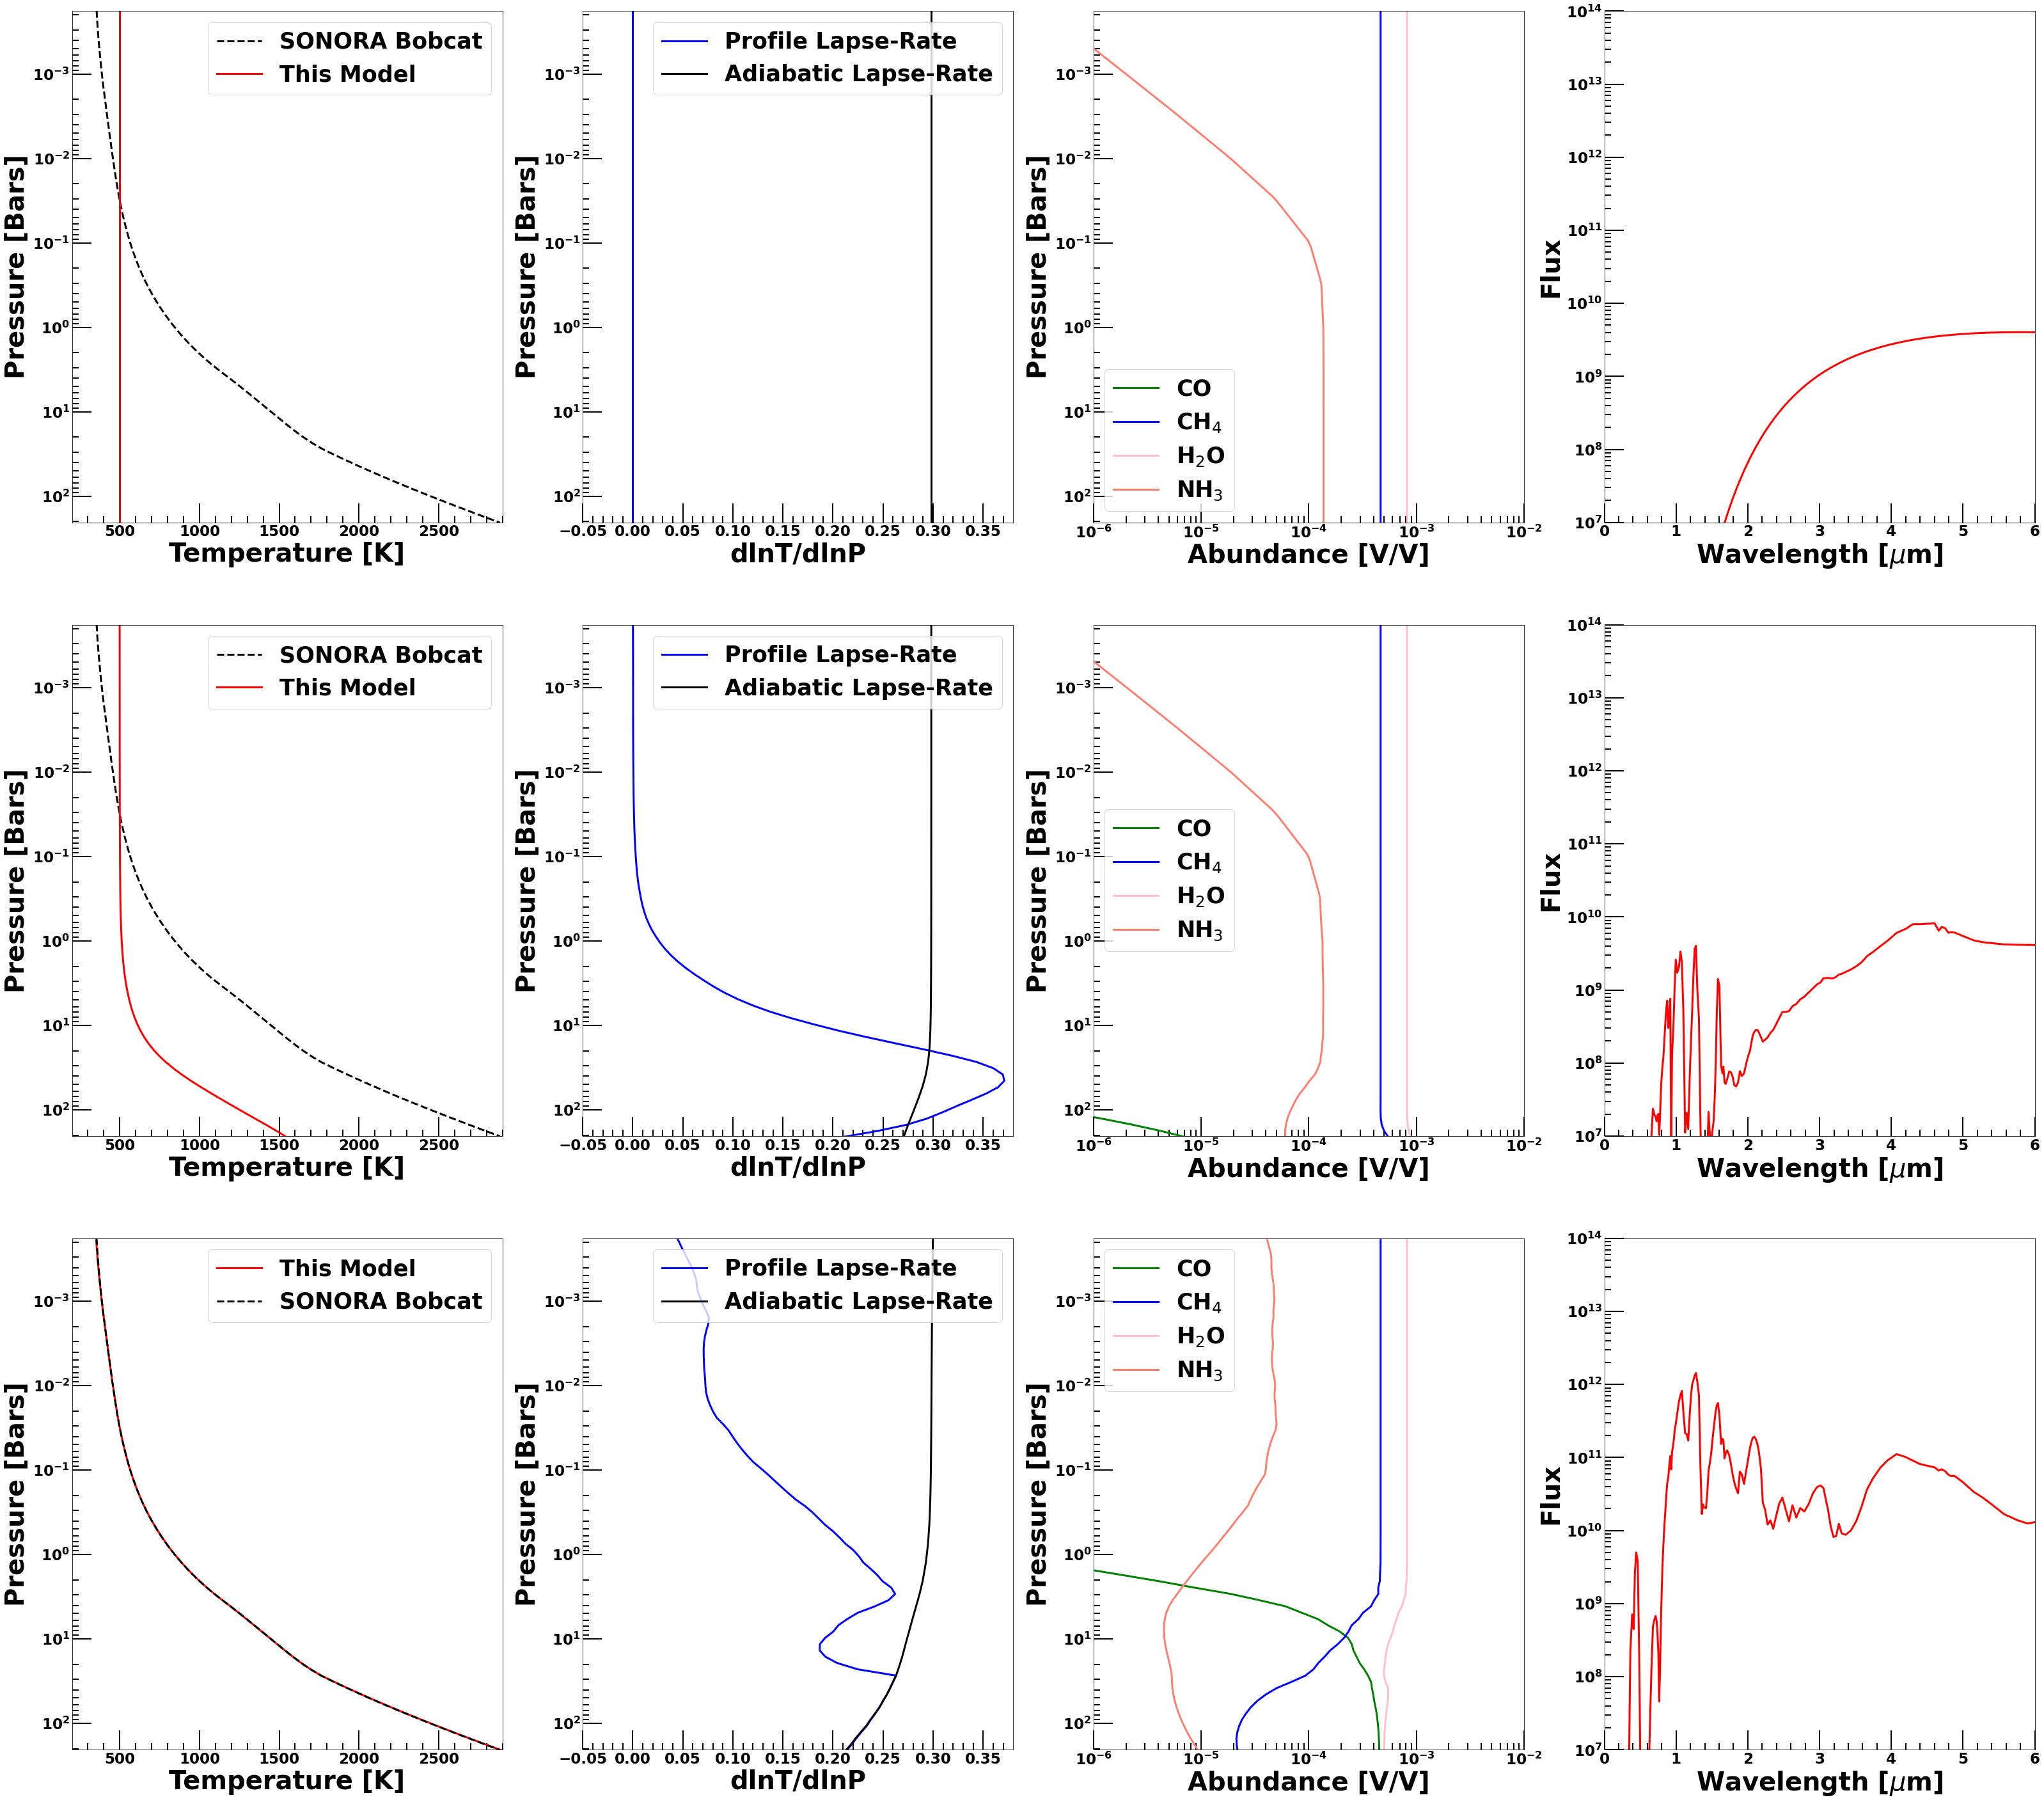

In [78]:
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"


x='''
AA.DD.BB.CC
EE.FF.GG.HH
II.JJ.KK.MM
'''
fig = plt.figure(figsize=(55,50))
ax = fig.subplot_mosaic(x,gridspec_kw={
        # set the height ratios between the rows
        "height_ratios": [1,1,1],
        # set the width ratios between the columns
        "width_ratios": [1,1,0.1,1,1,0.1,1,1,0.1,1,1]})

ct=0

ax['A'].semilogy(temp_bobcat,pressure_bobcat,color="k",linestyle="--",linewidth=3,label="SONORA Bobcat")
ax['A'].semilogy(all_profiles_eq[ct*91:(ct+1)*91], p_eq,linewidth=3,color='r',label="This Model")
ax['B'].loglog(co[ct*91:(ct+1)*91], p_eq,linewidth=3,color='g',label="CO")
ax['B'].loglog(ch4[ct*91:(ct+1)*91], p_eq,linewidth=3,color='b',label="CH$_4$")
ax['C'].semilogy(1e4/df_spec['wavenumber'], spec[ct,:],linewidth=3,color="r")
ax['B'].loglog(h2o[ct*91:(ct+1)*91], p_eq,linewidth=3,color='pink',label="H$_2$O")
ax['B'].loglog(nh3[ct*91:(ct+1)*91], p_eq,linewidth=3,color='salmon',label="NH$_3$")
ax['D'].semilogy(dtdp_arr[ct*91:(ct+1)*91], p_eq,linewidth=3,color='blue',label="Profile Lapse-Rate")
ax['D'].semilogy(grad_arr[ct*91:(ct+1)*91], p_eq,linewidth=3,color='k',label="Adiabatic Lapse-Rate")

ct=5

ax['E'].semilogy(temp_bobcat,pressure_bobcat,color="k",linestyle="--",linewidth=3,label="SONORA Bobcat")
ax['E'].semilogy(all_profiles_eq[ct*91:(ct+1)*91], p_eq,linewidth=3,color='r',label="This Model")
ax['G'].loglog(co[ct*91:(ct+1)*91], p_eq,linewidth=3,color='g',label="CO")
ax['G'].loglog(ch4[ct*91:(ct+1)*91], p_eq,linewidth=3,color='b',label="CH$_4$")
ax['H'].semilogy(1e4/df_spec['wavenumber'], spec[ct,:],linewidth=3,color="r")
ax['G'].loglog(h2o[ct*91:(ct+1)*91], p_eq,linewidth=3,color='pink',label="H$_2$O")
ax['G'].loglog(nh3[ct*91:(ct+1)*91], p_eq,linewidth=3,color='salmon',label="NH$_3$")
ax['F'].semilogy(dtdp_arr[ct*91:(ct+1)*91], p_eq,linewidth=3,color='blue',label="Profile Lapse-Rate")
ax['F'].semilogy(grad_arr[ct*91:(ct+1)*91], p_eq,linewidth=3,color='k',label="Adiabatic Lapse-Rate")

ct=76

ax['I'].semilogy(all_profiles_eq[ct*91:(ct+1)*91], p_eq,linewidth=3,color='r',label="This Model")
ax['I'].semilogy(temp_bobcat,pressure_bobcat,color="k",linestyle="--",linewidth=3,label="SONORA Bobcat")
ax['K'].loglog(co[ct*91:(ct+1)*91], p_eq,linewidth=3,color='g',label="CO")
ax['K'].loglog(ch4[ct*91:(ct+1)*91], p_eq,linewidth=3,color='b',label="CH$_4$")
ax['M'].semilogy(1e4/df_spec['wavenumber'], spec[ct,:],linewidth=3,color="r")
ax['K'].loglog(h2o[ct*91:(ct+1)*91], p_eq,linewidth=3,color='pink',label="H$_2$O")
ax['K'].loglog(nh3[ct*91:(ct+1)*91], p_eq,linewidth=3,color='salmon',label="NH$_3$")
ax['J'].semilogy(dtdp_arr[ct*91:(ct+1)*91], p_eq,linewidth=3,color='blue',label="Profile Lapse-Rate")
ax['J'].semilogy(grad_arr[ct*91:(ct+1)*91], p_eq,linewidth=3,color='k',label="Adiabatic Lapse-Rate")

ax['A'].set_xlabel('Temperature [K]',fontsize=40)
ax['A'].set_ylabel('Pressure [Bars]',fontsize=40)
ax['A'].set_xlim(200,2900)
ax['A'].set_ylim(205,1.8e-4)
ax['A'].legend(fontsize=35)
ax['D'].set_xlabel('dlnT/dlnP',fontsize=40)
ax['D'].set_ylabel('Pressure [Bars]',fontsize=40)
ax['D'].set_xlim(-.05,0.38)
ax['D'].set_ylim(205,1.8e-4)
ax['D'].legend(fontsize=35,loc="upper right")
ax['B'].set_xlabel('Abundance [V/V]',fontsize=40)
ax['B'].set_ylabel('Pressure [Bars]',fontsize=40)
ax['B'].set_xlim(1e-6,1e-2)
ax['B'].set_ylim(205,1.8e-4)
ax['B'].legend(fontsize=35)
ax['C'].set_xlabel('Wavelength [$\mu$m]',fontsize=40)
ax['C'].set_ylabel('Flux',fontsize=40)
ax['C'].set_xlim(0,6)
ax['C'].set_ylim(1e7,1e14)
ax['A'].minorticks_on()
ax['A'].tick_params(axis='both',which='major',length =30, width=2,direction='in',labelsize=23)
ax['A'].tick_params(axis='both',which='minor',length =10, width=2,direction='in',labelsize=23)
ax['B'].minorticks_on()
ax['B'].tick_params(axis='both',which='major',length =30, width=2,direction='in',labelsize=23)
ax['B'].tick_params(axis='both',which='minor',length =10, width=2,direction='in',labelsize=23)
ax['C'].minorticks_on()
ax['C'].tick_params(axis='both',which='major',length =30, width=2,direction='in',labelsize=23)
ax['C'].tick_params(axis='both',which='minor',length =10, width=2,direction='in',labelsize=23)
ax['D'].minorticks_on()
ax['D'].tick_params(axis='both',which='major',length =30, width=2,direction='in',labelsize=23)
ax['D'].tick_params(axis='both',which='minor',length =10, width=2,direction='in',labelsize=23)

ax['E'].set_xlabel('Temperature [K]',fontsize=40)
ax['E'].set_ylabel('Pressure [Bars]',fontsize=40)
ax['E'].set_xlim(200,2900)
ax['E'].set_ylim(205,1.8e-4)
ax['E'].legend(fontsize=35)
ax['F'].set_xlabel('dlnT/dlnP',fontsize=40)
ax['F'].set_ylabel('Pressure [Bars]',fontsize=40)
ax['F'].set_xlim(-0.05,0.38)
ax['F'].set_ylim(205,1.8e-4)
ax['F'].legend(fontsize=35,loc="upper right")
ax['G'].set_xlabel('Abundance [V/V]',fontsize=40)
ax['G'].set_ylabel('Pressure [Bars]',fontsize=40)
ax['G'].set_xlim(1e-6,1e-2)
ax['G'].set_ylim(205,1.8e-4)
ax['G'].legend(fontsize=35)
ax['H'].set_xlabel('Wavelength [$\mu$m]',fontsize=40)
ax['H'].set_ylabel('Flux',fontsize=40)
ax['H'].set_xlim(0,6)
ax['H'].set_ylim(1e7,1e14)
ax['E'].minorticks_on()
ax['E'].tick_params(axis='both',which='major',length =30, width=2,direction='in',labelsize=23)
ax['E'].tick_params(axis='both',which='minor',length =10, width=2,direction='in',labelsize=23)
ax['F'].minorticks_on()
ax['F'].tick_params(axis='both',which='major',length =30, width=2,direction='in',labelsize=23)
ax['F'].tick_params(axis='both',which='minor',length =10, width=2,direction='in',labelsize=23)
ax['G'].minorticks_on()
ax['G'].tick_params(axis='both',which='major',length =30, width=2,direction='in',labelsize=23)
ax['G'].tick_params(axis='both',which='minor',length =10, width=2,direction='in',labelsize=23)
ax['H'].minorticks_on()
ax['H'].tick_params(axis='both',which='major',length =30, width=2,direction='in',labelsize=23)
ax['H'].tick_params(axis='both',which='minor',length =10, width=2,direction='in',labelsize=23)

ax['I'].set_xlabel('Temperature [K]',fontsize=40)
ax['I'].set_ylabel('Pressure [Bars]',fontsize=40)
ax['I'].set_xlim(200,2900)
ax['I'].set_ylim(205,1.8e-4)
ax['I'].legend(fontsize=35)
ax['J'].set_xlabel('dlnT/dlnP',fontsize=40)
ax['J'].set_ylabel('Pressure [Bars]',fontsize=40)
ax['J'].set_xlim(-0.05,0.38)
ax['J'].set_ylim(205,1.8e-4)
ax['J'].legend(fontsize=35,loc="upper right")
ax['K'].set_xlabel('Abundance [V/V]',fontsize=40)
ax['K'].set_ylabel('Pressure [Bars]',fontsize=40)
ax['K'].set_xlim(1e-6,1e-2)
ax['K'].set_ylim(205,1.8e-4)
ax['K'].legend(fontsize=35)
ax['M'].set_xlabel('Wavelength [$\mu$m]',fontsize=40)
ax['M'].set_ylabel('Flux',fontsize=40)
ax['M'].set_xlim(0,6)
ax['M'].set_ylim(1e7,1e14)
ax['I'].minorticks_on()
ax['I'].tick_params(axis='both',which='major',length =30, width=2,direction='in',labelsize=23)
ax['I'].tick_params(axis='both',which='minor',length =10, width=2,direction='in',labelsize=23)
ax['J'].minorticks_on()
ax['J'].tick_params(axis='both',which='major',length =30, width=2,direction='in',labelsize=23)
ax['J'].tick_params(axis='both',which='minor',length =10, width=2,direction='in',labelsize=23)
ax['K'].minorticks_on()
ax['K'].tick_params(axis='both',which='major',length =30, width=2,direction='in',labelsize=23)
ax['K'].tick_params(axis='both',which='minor',length =10, width=2,direction='in',labelsize=23)
ax['M'].minorticks_on()
ax['M'].tick_params(axis='both',which='major',length =30, width=2,direction='in',labelsize=23)
ax['M'].tick_params(axis='both',which='minor',length =10, width=2,direction='in',labelsize=23)

fig.subplots_adjust(wspace=0,hspace=0)
plt.savefig("Benchmarking/iteration_BD.pdf",bbox_inches='tight')
